<a href="https://colab.research.google.com/github/gnomez1208/gnomez1208/blob/Dark-Matter-Research/LDR_waveform_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install uproot

from google.colab import files

print("Please select 'output03048.root' from your Ubuntu machine.")
uploaded = files.upload()
#saved onto google colab local file environment


Please select 'output03048.root' from your Ubuntu machine.


Saving output03048.root to output03048 (2).root


#**Creating the Waveform**
- want a moving average fit
- including a low and high pass filter

In [16]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter, filtfilt

'''
-----------things to note from MIDAS-----------
y axis - ADC counts per 4ns
- most if not all in range of 7000-8000 (wide)
- tigher range could be 7200 - 7600
x axis - time in ns (window for each waveform is 5000 ns)

'''



def butter_highpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    print(f"High-pass filter: cutoff={cutoff}, fs={fs}, nyq={nyq}, normal_cutoff={normal_cutoff}")
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    print(f"Low-pass filter: cutoff={cutoff}, fs={fs}, nyq={nyq}, normal_cutoff={normal_cutoff}")
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


def moving_average_filter(data, window_size):
    """
    Applies a moving average filter to the data. Be careful with bounds!
    Ended up needing to add a filtfilt function so that the df values length were conserved
    """
    a = 1
    b = np.ones(window_size) / window_size

    return filtfilt(b, a, data)

## Make a Dataframe with Filters


In [17]:

#  1. DEFINING EXPERIMENTAL PARAMETERS
# ==============================================================================
sampling_period_ns = 4
integration_window_ns = 250
pre_trigger_ns = 200
pre_trigger_samples = int(pre_trigger_ns / sampling_period_ns)
sampling_frequency = 1 / (sampling_period_ns * 1e-9) # In Hz

# --- Select and load a single waveform ---
waveform_index_to_plot = 813
with uproot.open(file_path) as file:
    key = file.keys()[waveform_index_to_plot]
    waveform_np = file[key].values()

# --- Create the initial DataFrame ---
time_ns = np.arange(len(waveform_np)) * sampling_period_ns
df = pd.DataFrame({'Time (ns)': time_ns, 'Raw ADC': waveform_np})

# --- Perform baseline subtraction ---
baseline = df['Raw ADC'][:pre_trigger_samples].mean()
df['Baseline Subtracted'] = df['Raw ADC'] - baseline

# --- Apply filters and add them as new columns to the DataFrame ---
print("Applying filters...")

# Apply a high-pass filter
df['High-Pass'] = butter_highpass_filter(df['Baseline Subtracted'], cutoff=1e6, fs=sampling_frequency)

# Apply a low-pass filter
df['Low-Pass'] = butter_lowpass_filter(df['Baseline Subtracted'], cutoff=10e6, fs=sampling_frequency)

# Create a band-pass filter by applying the low-pass to the high-passed signal
df['Band-Pass'] = butter_lowpass_filter(df['High-Pass'], cutoff=10e6, fs=sampling_frequency)

# Apply the zero-phase moving average filter
df['Moving Average'] = moving_average_filter(df['Baseline Subtracted'], window_size=20)

print("\n--- DataFrame with all filtered data ---")
display(df.head())

Applying filters...
High-pass filter: cutoff=1000000.0, fs=249999999.99999997, nyq=124999999.99999999, normal_cutoff=0.008
Low-pass filter: cutoff=10000000.0, fs=249999999.99999997, nyq=124999999.99999999, normal_cutoff=0.08000000000000002
Low-pass filter: cutoff=10000000.0, fs=249999999.99999997, nyq=124999999.99999999, normal_cutoff=0.08000000000000002

--- DataFrame with all filtered data ---


,Time (ns),Raw ADC,Baseline Subtracted,High-Pass,Low-Pass,Band-Pass,Moving Average
0,0,7421.0,-36.459961,-27.734841,-37.316159,-28.586648,-36.459961
1,4,7419.0,-38.459961,-30.012114,-40.294250,-31.871237,-36.849961
2,8,7419.0,-38.459961,-30.294736,-43.203492,-35.084005,-37.177461
3,12,7421.0,-36.459961,-28.582665,-45.931322,-38.113023,-37.419961
4,16,7417.0,-40.459961,-32.875851,-48.362937,-40.844345,-37.562461


## Let's create the waveform, finally

In [39]:
# Plot the comparison
# Get Peaks

peaks_base, _ = find_peaks(-df['Baseline Subtracted'], prominence=5, distance=20)
peaks_mav, _ = find_peaks(-df['Moving Average'], prominence=2, distance=20)

fig = go.Figure()

# Add the original baseline-subtracted trace
fig.add_trace(go.Scatter(
    x=df['Time (ns)'], y=df['Baseline Subtracted'],
    name='Baseline Subtracted (Original)', mode='lines',
    line=dict(color='red', width = 1.5)
))

# Add traces for each filtered waveform
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Band-Pass'], name='Band-Pass Filter', mode='lines', line=dict(width=2, color = 'green')))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Moving Average'], name='Moving Average', mode='lines', line=dict(width=2, color = 'blue')))

fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['High-Pass'], name='High-Pass Only', mode='lines', visible='legendonly'))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Low-Pass'], name='Low-Pass Only', mode='lines', visible='legendonly'))


#Peak Markers

# Markers for Baseline Subtracted peaks
fig.add_trace(go.Scatter(
    x=df['Time (ns)'].iloc[peaks_base], y=df['Baseline Subtracted'].iloc[peaks_base],
    name='Baseline Subtracted Peaks', mode='markers',
    marker=dict(color='red', symbol='diamond', size=8, line=dict(width=1,color = 'black') )
))

# Markers for Moving Average peaks
fig.add_trace(go.Scatter(
    x=df['Time (ns)'].iloc[peaks_mav], y=df['Moving Average'].iloc[peaks_mav],
    name='Moving Average Peaks', mode='markers',
    marker=dict(color='blue', symbol='x', size=8, line=dict(width=1))
))

# Update layout for clarity
fig.update_layout(
    title_text=f"Comparison of Zero-Phase Filters (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="ADC Value (Baseline Subtracted)",
    legend_title="Filter Type",
)

fig.show()

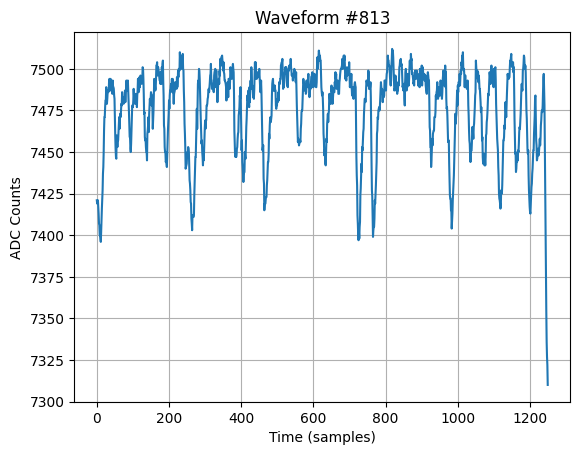

In [22]:
#======================================
# Check what waveform should look like
#======================================

import matplotlib.pyplot as plt

with uproot.open(file_path) as file:
    keys = file.keys()
    if waveform_index_to_plot < len(keys):
        wf_key = keys[waveform_index_to_plot]
        waveform_np = file[wf_key].values()
        plt.plot(waveform_np)
        plt.title(f"Waveform #{waveform_index_to_plot}")
        plt.xlabel("Time (samples)")
        plt.ylabel("ADC Counts")
        plt.grid(True)
        plt.show()
    else:
        print(f"Invalid waveform index: {waveform_index_to_plot}")

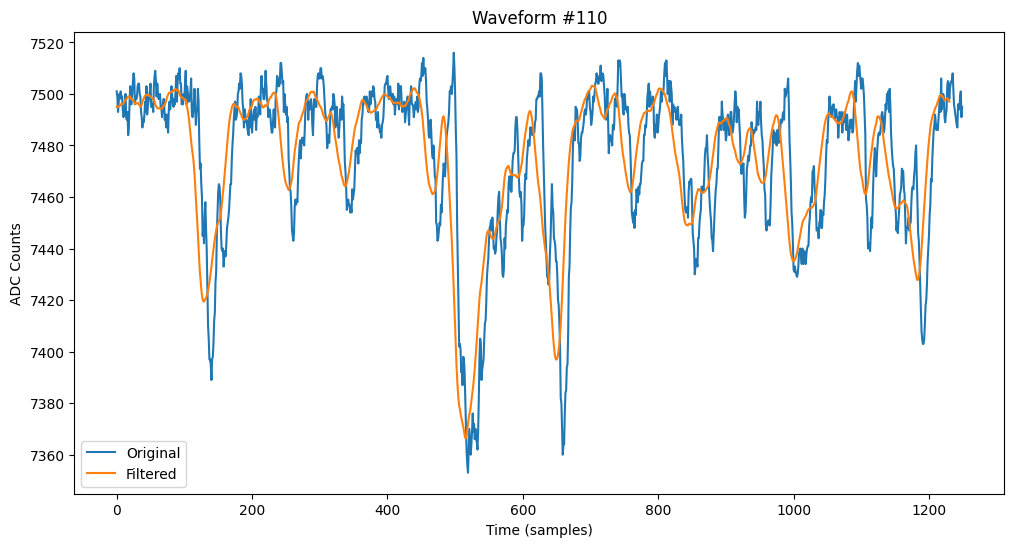

In [20]:
import matplotlib.pyplot as plt

with uproot.open(file_path) as file:
    keys = file.keys()
    if waveform_index_to_plot < len(keys):
        wf_key = keys[waveform_index_to_plot]
        waveform_np = file[wf_key].values()

        filtered_waveform = moving_average(waveform_np, moving_average_window_size)

        plt.figure(figsize=(12, 6))
        plt.plot(waveform_np, label='Original')
        plt.plot(filtered_waveform, label='Filtered')
        plt.title(f"Waveform #{waveform_index_to_plot}")
        plt.xlabel("Time (samples)")
        plt.ylabel("ADC Counts")
        plt.legend()
        plt.show()